# Organize ML projects with Scikit-Learn

While Machine Learning is powerful, people often overestimate it: apply machine learning to your project, and all your problems will be solved. In reality, it's not this simple. To be effective, one needs to organize the work very well. In this notebook, we will walkthrough practical aspects of a ML project. To look at the big picture, let's start with a checklist below. It should work reasonably well for most ML projects, but make sure to adapt it to your needs:

1. **Define the scope of work and objective**
    * How is your solution be used?
    * How should performance be measured? Are there any contraints?
    * How would the problem be solved manually?
    * List the available assumptions, and verify if possible.
    
    
2. **Get the data**
    * Document where you can get that data
    * Store data in a workspace you can easily access
    * Convert the data to a format you can easily manipulate
    * Check the overview (size, type, sample, description, statistics)
    * Data cleaning
    
    
3. **EDA & Data transformation**
    * Study each attribute and its characteristics (missing values, type of distribution, usefulness)
    * Visualize the data
    * Study the correlations between attributes
    * Feature selection, Feature Engineering, Feature scaling
    * Write functions for all data transformations
    
    
4. **Train models**
    * Automate as much as possible
    * Train promising models quickly using standard parameters. Measure and compare their performance
    * Analyze the errors the models make
    * Shortlist the top three of five most promising models, preferring models that make different types of errors.


5. **Fine-tunning**
    * Treat data transformation choices as hyperparameters, expecially when you are not sure about them (e.g., replace missing values with zeros or with the median value)
    * Unless there are very few hyperparameter value to explore, prefer random search over grid search.
    * Try ensemble methods
    * Test your final model on the test set to estimate the generalizaiton error. Don't tweak your model again, you would start overfitting the test set.

## Example: Articles categorization

### Objectives

Build a model to determine the categories of articles. 

### Get Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [2]:
bbc = pd.read_csv('https://raw.githubusercontent.com/dhminh1024/practice_datasets/master/bbc-text.csv')
bbc

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [3]:
bbc['category_id'] = bbc['category'].factorize()[0]
bbc

,category,text,category_id
0,tech,tv future in the hands of viewers with home th...,0
1,business,worldcom boss left books alone former worldc...,1
2,sport,tigers wary of farrell gamble leicester say ...,2
3,sport,yeading face newcastle in fa cup premiership s...,2
4,entertainment,ocean s twelve raids box office ocean s twelve...,3
...,...,...,...
2220,business,cars pull down us retail figures us retail sal...,1
2221,politics,kilroy unveils immigration policy ex-chatshow ...,4
2222,entertainment,rem announce new glasgow concert us band rem h...,3
2223,politics,how political squabbles snowball it s become c...,4


In [4]:
category_df = bbc[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_df

,category,category_id
0,tech,0
1,business,1
2,sport,2
4,entertainment,3
5,politics,4


In [5]:
category_to_id = dict(category_df.values)
id_to_category = dict(category_df[['category_id', 'category']].values)

In [6]:
id_to_category

{0: 'tech', 1: 'business', 2: 'sport', 3: 'entertainment', 4: 'politics'}

In [7]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
labels = bbc['category_id']
features = tfidf.fit_transform(bbc['text']).toarray()

In [9]:
sorted(category_to_id.items())

[('business', 1),
 ('entertainment', 3),
 ('politics', 4),
 ('sport', 2),
 ('tech', 0)]

In [11]:
from sklearn.feature_selection import chi2

N = 3  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)                   # Do chi2 analyses of all items in this category
  indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
  feature_names = np.array(tfidf.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
  print("# '{}':".format(category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# 'business':
  . Most correlated unigrams:
       . oil
       . growth
       . shares
  . Most correlated bigrams:
       . analysts said
       . economic growth
       . stock market
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . actor
       . film
  . Most correlated bigrams:
       . los angeles
       . film festival
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . coach
       . match
       . cup
  . Most correlated bigrams:
       . grand slam
       . australian open
       . champions league
# 'tech':
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . anti virus
       . mobile phones
       . mobile phone


In [12]:
features_chi2

(array([0.00355164, 0.29252643, 0.67297617, ..., 0.02810703, 0.13112208,
        0.17836794]),
 array([0.95247768, 0.58860607, 0.4120159 , ..., 0.86685744, 0.71727145,
        0.67277957]))

In [13]:
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)          # Randomly select 30 % of samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]) # Array of all projected features of 30% of Randomly chosen samples 

In [14]:
my_id = 0 # Select a category_id
projected_features[(labels[indices] == my_id).values]

array([[ -0.16318959, -34.774166  ],
       [ -7.4001145 , -21.932173  ],
       [-13.47091   , -26.779797  ],
       [ -2.9177837 , -30.838398  ],
       [  1.2880018 ,   9.515079  ],
       [ -5.5880485 , -18.306005  ],
       [-10.556862  , -19.946003  ],
       [-10.604404  , -11.073941  ],
       [  0.43310818, -15.034451  ],
       [  3.0339568 , -29.396107  ],
       [-18.82653   , -32.288883  ],
       [ -4.202493  , -16.4908    ],
       [  0.10764528,  -8.134516  ],
       [ -0.07343149, -27.399202  ],
       [  4.490872  , -17.756474  ],
       [ -2.930044  , -30.81452   ],
       [ -5.7378526 , -10.311122  ],
       [ -6.5839987 , -13.346011  ],
       [ -6.835629  , -17.658325  ],
       [ -1.7854143 , -36.18077   ],
       [ -2.9322968 , -34.106213  ],
       [-17.832575  , -31.916248  ],
       [ -7.2202554 , -17.777195  ],
       [-10.436928  , -25.830317  ],
       [-10.717158  , -27.027716  ],
       [ -4.7013955 , -22.477373  ],
       [ 31.966625  ,  -9.982791  ],
 

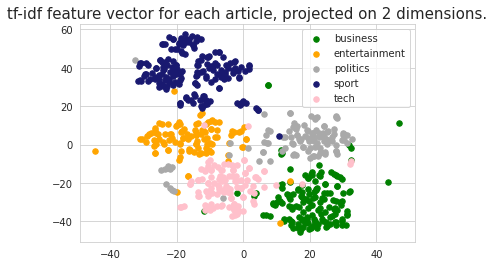

In [15]:
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']

# Find points belonging to each category and plot them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

In [16]:
features.shape

(2225, 14415)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [18]:
CV = 5  # Cross Validate with 5 different folds of 20% data ( 80-20 split with 5 folds )

#Create a data frame that will store the results for all 5 trials of the 3 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] # Initially all entries are empty

In [19]:
for model in models:
  model_name = model.__class__.__name__
  # create 5 models with different 20% test sets, and store their accuracies
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 3x5 = 15 entries)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

In [20]:
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


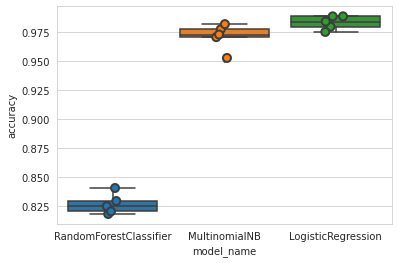

In [21]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

In [22]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.983371
MultinomialNB             0.971236
RandomForestClassifier    0.826517
Name: accuracy, dtype: float64

In [30]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, bbc.index, test_size=0.33, random_state=0)

#Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

Text(0.5, 15.0, 'Predicted')

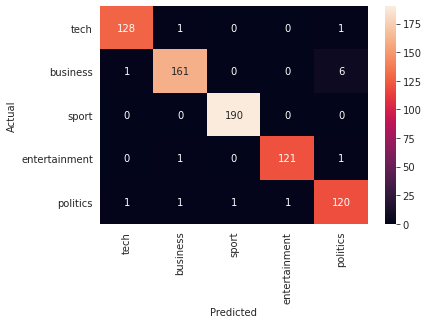

In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_df.category.values, yticklabels=category_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [32]:
accuracy_score(y_test, y_pred)

0.9795918367346939